<a href="https://colab.research.google.com/github/albertofalco/M72/blob/main/M72_09_Actividad_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
ME72: Maestría en Métodos Cuantitativos para la Gestión y Análisis de Datos
M72109: Analisis de datos no estructurados
Universidad de Buenos Aires - Facultad de Ciencias Economicas (UBA-FCE)
Año: 2023
Profesor: Facundo Santiago
```

```
Alumno: Alberto Falco
```

# Actividad Final: ¿Qué tan memorable es un video?

## 1. Preparación del ambiente

### 1.1. Descarga de sets de datos

In [1]:
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Desafio/Data/ground_truth.csv --directory-prefix ./Data/ --quiet
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/Desafio/Data/Features/caption_features.csv --directory-prefix ./Data/Features/ --quiet

### 1.2. Descarga de librerias y modulos necesarios

In [2]:
!wget -N https://raw.githubusercontent.com/albertofalco/M72/main/09/final/requirements.txt --quiet
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/m72109/nlp/datasets.py --directory-prefix ./m72109/nlp/ --quiet
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/m72109/nlp/explanation.py --directory-prefix ./m72109/nlp/ --quiet
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/m72109/nlp/normalization.py --directory-prefix ./m72109/nlp/ --quiet
!wget -N https://raw.githubusercontent.com/santiagxf/M72109/master/m72109/nlp/transformation.py --directory-prefix ./m72109/nlp/ --quiet
!wget -N https://santiagxf.blob.core.windows.net/public/Word2Vec/model-en.bin --directory-prefix ./Models/Word2Vec --quiet

### 1.3. Instalación de librerias

In [3]:
! pip install --upgrade -r requirements.txt --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.2 MB/s eta 0:00:00


## 2. Importación de librerías

In [4]:
# Importación de librerias.
import pandas as pd
import numpy as np
import os
import torch
import transformers

# from transformers import BertForSequenceClassification
# from transformers import Trainer, TrainingArguments

# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report

# from m72109.nlp.normalization import TextNormalizer, TweetTextNormalizer
# from m72109.nlp.transformation import Word2VecVectorizer, PadSequenceTransformer, split_text_with_context
# from m72109.nlp.explanation import get_explanation_from_grads, locate_token

In [5]:
# Verificación de la unidad de procesamiento.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

print("Este notebook se está ejecutando en {}.".format(device))

Este notebook se está ejecutando en cuda.


## 3. Obtención de datos


 - **memorability_score:** Representa el puntaje de memorabilidad de la secuencia en particular, desde 0 a 1. Valores más grandes son mejores.
 - **memorable:** Variable categórica que representa si un video es memorable o no. Un video con `memorability_score` superior a `0.5` es marcado como memorable (`1`), sino es marcado como no memorable (`0`)

In [6]:
# Carga de labels.
labels = pd.read_csv('Data/ground_truth.csv')

In [7]:
# Impresion de los primeros registros.
labels.head(2)

,movie_name,start(sec),end(sec),sequence_name,Neutral (1)_Typical (0),nb_annotations,memorability_score,memorable
0,127 hours,2000,2010,127_hours_2000_2010_1,0,5,1.0,1
1,127 hours,2182,2192,127_hours_2182_2192_5,1,8,0.0,0


In [8]:
# Impresion del shape de labels.
labels.shape

(660, 8)

In [9]:
# Carga de captions.
captions = pd.read_csv('Data/Features/caption_features.csv')

In [10]:
# Impresión de los primeros registros.
captions.head(2)

,sequence_name,cc
0,127_hours_2000_2010_1,a man in a suit and tie standing in front of a...
1,127_hours_2182_2192_5,a man holding a toothbrush in his mouth. a wom...


In [11]:
# Impresion del shape de captions.
captions.shape

(660, 2)

## 4. Preprocesamiento

In [12]:
# Preparación de dataset para entrenamiento y prueba.
from datasets import Dataset, ClassLabel, Features, Value

df = pd.DataFrame({'text': captions['cc'], 'labels': labels['memorable']}, index=None)

dataset = Dataset.from_pandas(
    df=df,
    features=Features({
        'text': Value("string"),
        'labels': ClassLabel(names=[int(i) for i in labels['memorable'].unique()])
    })
)

In [13]:
# División del dataset.
train_test = dataset.train_test_split(train_size=0.7, stratify_by_column='labels')

In [14]:
# Estructura del dataset.
train_test

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 461
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 199
    })
})

## 5. Uso de Word2Vec - RNN - LSTM

### 5.1. Ingeniería de predictores

In [ ]:
# Instalación de vocabulario de spaCy para lemmatizer.
! python -m spacy download 'en_core_web_sm' --quiet

2023-11-22 21:28:23.130687: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 21:28:23.130747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 21:28:23.130786: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-22 21:28:24.612944: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 32.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
# Descarga de perluniprops para tokenizer.
import nltk
nltk.download('perluniprops')

[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.


True

In [ ]:
# Instanciacion del normalizer.
from m72109.nlp.normalization import TextNormalizer
from nltk.tokenize.nist import NISTTokenizer
from nltk.tokenize.casual import TweetTokenizer

normalizer = TextNormalizer(tokenizer=NISTTokenizer(),
                            language="english",
                            lemmatize=False,
                            stem=False,
                            strip_urls=False,
                            strip_accents=True,
                            token_min_len=2,
                            preserve_case=False,
                            strip_stopwords=True,
                            return_tokens=True)

In [ ]:
# Instanciacion del vectorizer y embeddings.
from m72109.nlp.transformation import Word2VecVectorizer
w2v = Word2VecVectorizer(model='./Models/Word2Vec/model-en.bin',
                         sequence_to_idx=True)
embedding_weights = w2v.get_weights().astype("float16")
embedding_size = w2v.emdedding_size
vocab_size = w2v.vocab_size

/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(
100%|██████████| 4027170/4027170 [00:09<00:00, 435572.18it/s]


In [ ]:
# Instanciación del padder.
from m72109.nlp.transformation import PadSequenceTransformer
max_seq_len = 100
seq2seq = PadSequenceTransformer(max_len=max_seq_len)

### 5.2. Modelado

In [ ]:
# Construcción de la red neuronal.
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input, SpatialDropout1D

def build_model(sequence_len, vocab_size, embedding_size, embedding_weights):
  model = Sequential([
      Embedding(input_dim=vocab_size,
                output_dim=embedding_size,
                weights=[embedding_weights],
                trainable=False,
                mask_zero=True),
      SpatialDropout1D(0.2),
      LSTM(embedding_size),
      Dense(2, activation='softmax')
  ])
  model.compile(loss='sparse_categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [ ]:
# Instanciación del estimator.
from scikeras.wrappers import KerasClassifier

estimator = KerasClassifier(
    build_fn=build_model,
    epochs=5,
    sequence_len=max_seq_len,
    vocab_size=w2v.vocab_size,
    embedding_size=embedding_size,
    embedding_weights=embedding_weights,
    batch_size=8,
    validation_split=0.33
)

In [ ]:
# Construccion del pipeline de transformacion.
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[('normalizer', normalizer),
                           ('vectorizer', w2v),
                           ('padder', seq2seq),
                           ('estimator', estimator)
                           ])

In [ ]:
# Entrenamiento.
X_train = [doc["text"] for doc in train_test["train"]]
y_train = [doc["labels"] for doc in train_test["train"]]

model = pipeline.fit(X=X_train, y=y_train)

100%|██████████| 461/461 [00:00<00:00, 5806.77it/s]
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/5
39/39 [==============================] - 12s 50ms/step - loss: 0.7025 - accuracy: 0.5162 - val_loss: 0.6933 - val_accuracy: 0.4967
Epoch 2/5
39/39 [==============================] - 1s 14ms/step - loss: 0.6785 - accuracy: 0.5682 - val_loss: 0.6934 - val_accuracy: 0.5556
Epoch 3/5
39/39 [==============================] - 0s 12ms/step - loss: 0.6671 - accuracy: 0.5617 - val_loss: 0.6881 - val_accuracy: 0.4967
Epoch 4/5
39/39 [==============================] - 0s 11ms/step - loss: 0.6446 - accuracy: 0.5974 - val_loss: 0.6918 - val_accuracy: 0.5817
Epoch 5/5
39/39 [==============================] - 0s 12ms/step - loss: 0.6350 - accuracy: 0.6299 - val_loss: 0.6763 - val_accuracy: 0.5556


In [ ]:
# Datos de prueba.
X_test = [doc["text"] for doc in train_test["test"]]
y_test = [doc["labels"] for doc in train_test["test"]]

In [ ]:
# Obtencion de probabilidades.
probabilities = model.predict_proba(X_test)

# Obtención de predicciones.
predictions = np.argmax(probabilities, axis=1)

100%|██████████| 199/199 [00:00<00:00, 10652.78it/s]


25/25 [==============================] - 1s 4ms/step


In [ ]:
# Obtención de metricas.
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.62      0.69      0.65       111
           1       0.54      0.45      0.49        88

    accuracy                           0.59       199
   macro avg       0.58      0.57      0.57       199
weighted avg       0.58      0.59      0.58       199



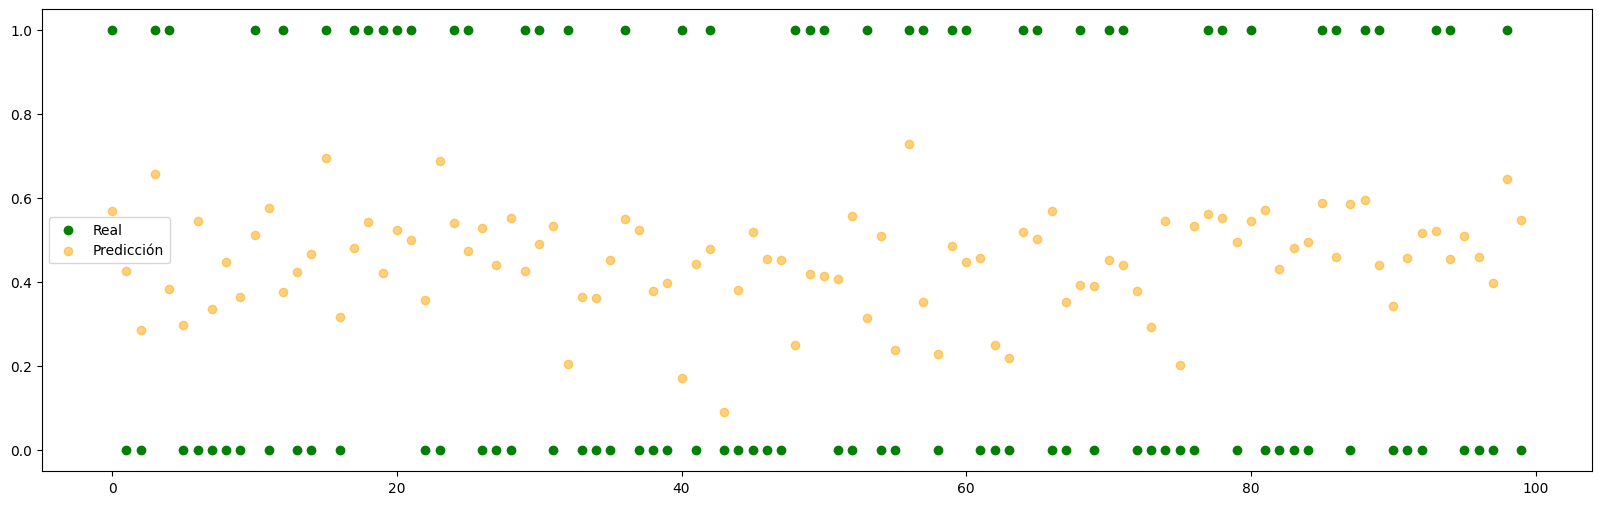

In [ ]:
# Representacion gráfica del ajuste del modelo (probabilidades y valores reales).
import matplotlib.pyplot as plt

docs_len = 100
indexes = [*range(len(y_test))][:docs_len]

fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(indexes, y_test[:docs_len], label='Real', color='green', alpha=1.0)
ax.scatter(indexes, probabilities[:,1][:docs_len], label='Predicción', color='orange', alpha=0.5)
ax.legend()
plt.show()

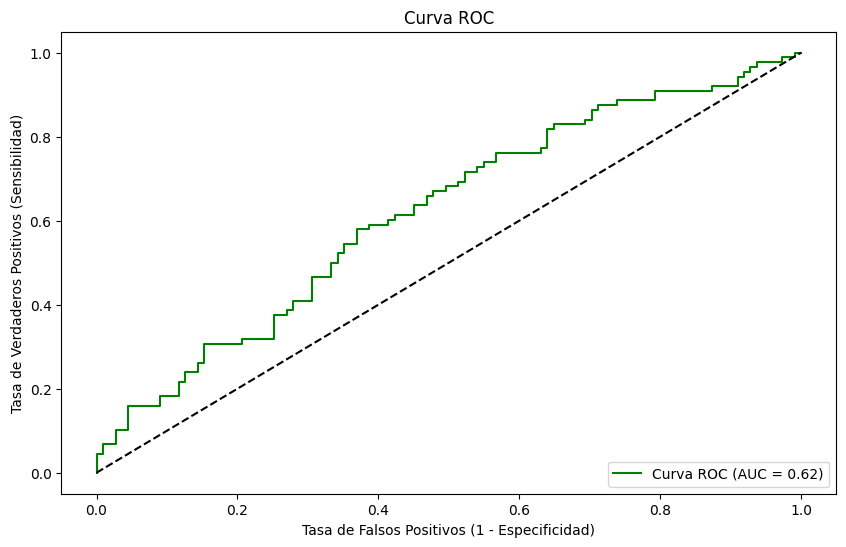

In [ ]:
# Representación gráfica de la curva ROC-AUC.
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcula la curva ROC.
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:,1])

# Calcula el valor AUC.
auc = roc_auc_score(y_test, probabilities[:,1])

# Grafica la curva ROC.
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % auc, color="green")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Persistencia del modelo.
from joblib import dump, load

dump(model, 'rnn_1.0.joblib')

['rnn_1.0.joblib']

## 6. Uso de transformers: Modelo BERT Base


In [ ]:
# Instanciación de tokenizer.
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Aplicación del tokenizer.
def tokenization(example):
    return tokenizer(example["text"], padding='max_length', truncation=True, return_tensors="pt")

train_test_tokenized = train_test.map(tokenization, batched=True, batch_size=16)

Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

In [ ]:
# Diseño del modelo.
from transformers import AutoModelForSequenceClassification

num_labels=len([int(i) for i in labels['memorable'].unique()])
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased',
                                                           num_labels=num_labels)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Summary del modelo.
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Configuración del Modelo BERT.
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir='./results',          # Directorio de trabajo del Trainer
    num_train_epochs=50,              # Numero total de epochs sobre el que entrenaremos
    warmup_steps=500,                # Numero de pasos que se usaran para determinar la politica de Learning Rate
    weight_decay=0.1,               # Weight decay
    logging_dir='./logs',            # Directorio de logs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16
)

In [ ]:
# Entrenamiento del modelo BERT.
trainer = Trainer(
    model=model,                         # modelo sobre el que haremos fine tunning
    args=training_args,                  # parametros del entrenamiento
    train_dataset=train_test_tokenized['train'],   # set de datos de entrenamiento
    eval_dataset=train_test_tokenized['test'],     # set de datos de evaluación
)

history = trainer.train()

Step,Training Loss
500,0.531800
1000,0.055800


In [ ]:
# Metricas del entrenamiento.
print(history)

TrainOutput(global_step=1450, training_loss=0.20332908696141735, metrics={'train_runtime': 2209.2009, 'train_samples_per_second': 10.434, 'train_steps_per_second': 0.656, 'total_flos': 6064709826048000.0, 'train_loss': 0.20332908696141735, 'epoch': 50.0})


In [ ]:
# Obtencion de y_pred / y_test.
predictions = trainer.predict(test_dataset=train_test_tokenized['test'])
y_test = train_test_tokenized['test']['labels']

In [ ]:
# Obtención de probabilidades.
input = torch.from_numpy(predictions[0])
m = torch.nn.Softmax(dim=1) # Función torch para convertir logits en probabilidades.
probabilities = m(input)

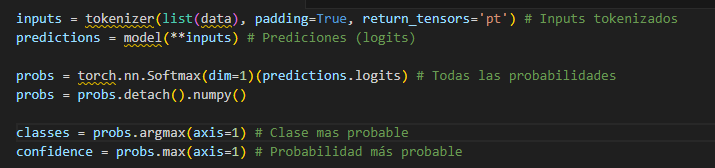

In [ ]:
# Obtención de predicciones.
y_pred = np.argmax(probabilities, axis=1)

# probabilities = np.apply_along_axis(arr=predictions[0],
#                                      func1d = lambda x: np.exp(x) / np.sum(np.exp(x)),
#                                      axis = 1)

In [ ]:
# Obtención de metricas.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.59      0.60      0.60       111
           1       0.49      0.48      0.48        88

    accuracy                           0.55       199
   macro avg       0.54      0.54      0.54       199
weighted avg       0.55      0.55      0.55       199



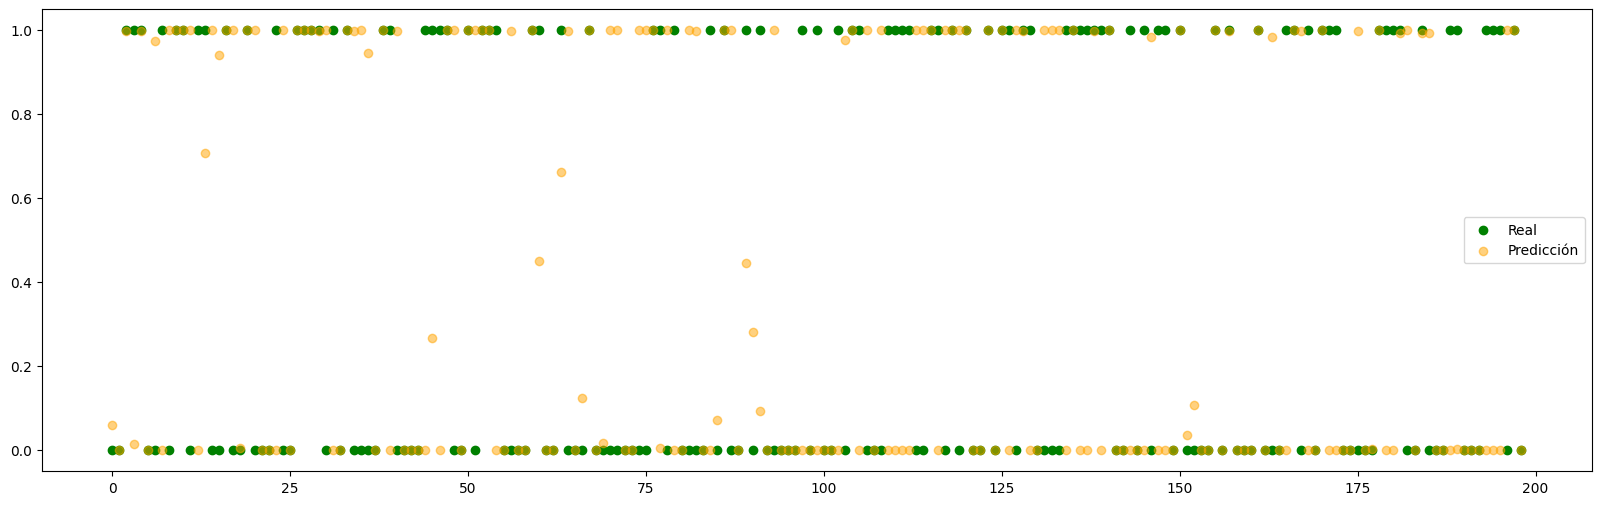

In [ ]:
# Representacion gráfica del ajuste del modelo (probabilidades y valores reales).
import matplotlib.pyplot as plt

docs_len = 199
indexes = [*range(len(y_pred))][:docs_len]

fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(indexes, y_test[:docs_len], label='Real', color='green', alpha=1.0)
ax.scatter(indexes, probabilities[:,1][:docs_len], label='Predicción', color='orange', alpha=0.5)
ax.legend()
plt.show()

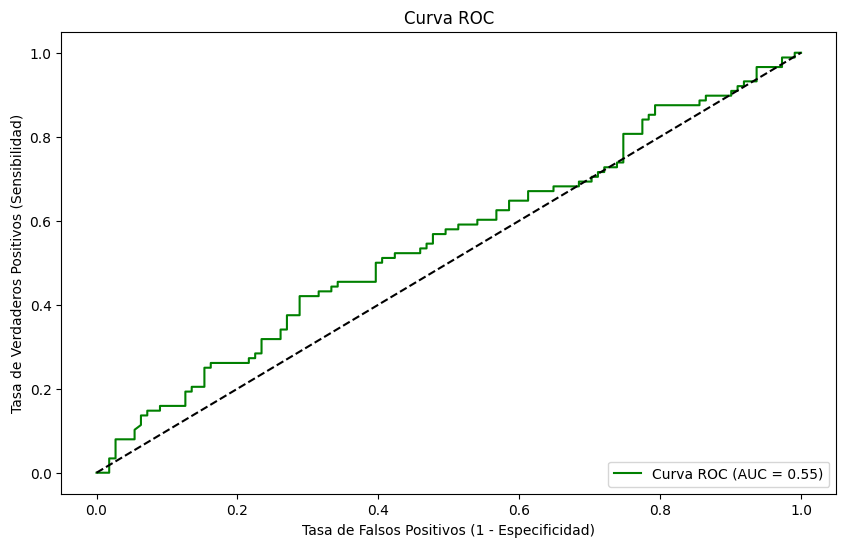

In [ ]:
# Representación gráfica de la curva ROC-AUC.
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcula la curva ROC.
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:,1])

# Calcula el valor AUC.
auc = roc_auc_score(y_test, probabilities[:,1])

# Grafica la curva ROC.
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % auc, color="green")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Limpieza de memoria.
import gc

# Garbage collector.
gc.collect()

# Limpieza de memoria cache.
torch.cuda.empty_cache()

## 7. Uso de BGE Embedding

In [ ]:
# Fuente:
# https://huggingface.co/BAAI/llm-embedder

In [15]:
# Instanciación de tokenizer.
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('BAAI/llm-embedder', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/396 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [16]:
# Aplicación del tokenizer.
def tokenization(example):
    return tokenizer(example["text"], padding='max_length', truncation=True, return_tensors="pt")

train_test_tokenized = train_test.map(tokenization, batched=True, batch_size=16)

Map:   0%|          | 0/461 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

In [17]:
# Diseño del modelo.
from transformers import AutoModelForSequenceClassification

num_labels=len([int(i) for i in labels['memorable'].unique()])
model = AutoModelForSequenceClassification.from_pretrained('BAAI/llm-embedder',
                                                           num_labels=num_labels)

config.json:   0%|          | 0.00/731 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/llm-embedder and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Summary del modelo.
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [19]:
# Configuración del modelo.
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling

training_args = TrainingArguments(
    output_dir='./results',          # Directorio de trabajo del Trainer
    num_train_epochs=50,              # Numero total de epochs sobre el que entrenaremos
    warmup_steps=500,                # Numero de pasos que se usaran para determinar la politica de Learning Rate
    weight_decay=0.1,               # Weight decay
    logging_dir='./logs',            # Directorio de logs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16
)

In [20]:
# Entrenamiento del modelo.
trainer = Trainer(
    model=model,                         # modelo sobre el que haremos fine tunning
    args=training_args,                  # parametros del entrenamiento
    train_dataset=train_test_tokenized['train'],   # set de datos de entrenamiento
    eval_dataset=train_test_tokenized['test'],     # set de datos de evaluación
)

history = trainer.train()

Step,Training Loss
500,0.410900
1000,0.039200


In [21]:
# Metricas del entrenamiento.
print(history)

TrainOutput(global_step=1450, training_loss=0.15522482506673912, metrics={'train_runtime': 2426.7531, 'train_samples_per_second': 9.498, 'train_steps_per_second': 0.598, 'total_flos': 6064709826048000.0, 'train_loss': 0.15522482506673912, 'epoch': 50.0})


In [23]:
# Obtencion de y_pred / y_test.
predictions = trainer.predict(test_dataset=train_test_tokenized['test'])
y_test = train_test_tokenized['test']['labels']

In [24]:
# Obtención de probabilidades.
input = torch.from_numpy(predictions[0])
m = torch.nn.Softmax(dim=1) # Función torch para convertir logits en probabilidades.
probabilities = m(input)

In [25]:
# Obtención de predicciones.
y_pred = np.argmax(probabilities, axis=1)

In [26]:
# Obtención de metricas.
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.63      0.68      0.66       111
           1       0.55      0.49      0.52        88

    accuracy                           0.60       199
   macro avg       0.59      0.59      0.59       199
weighted avg       0.59      0.60      0.59       199



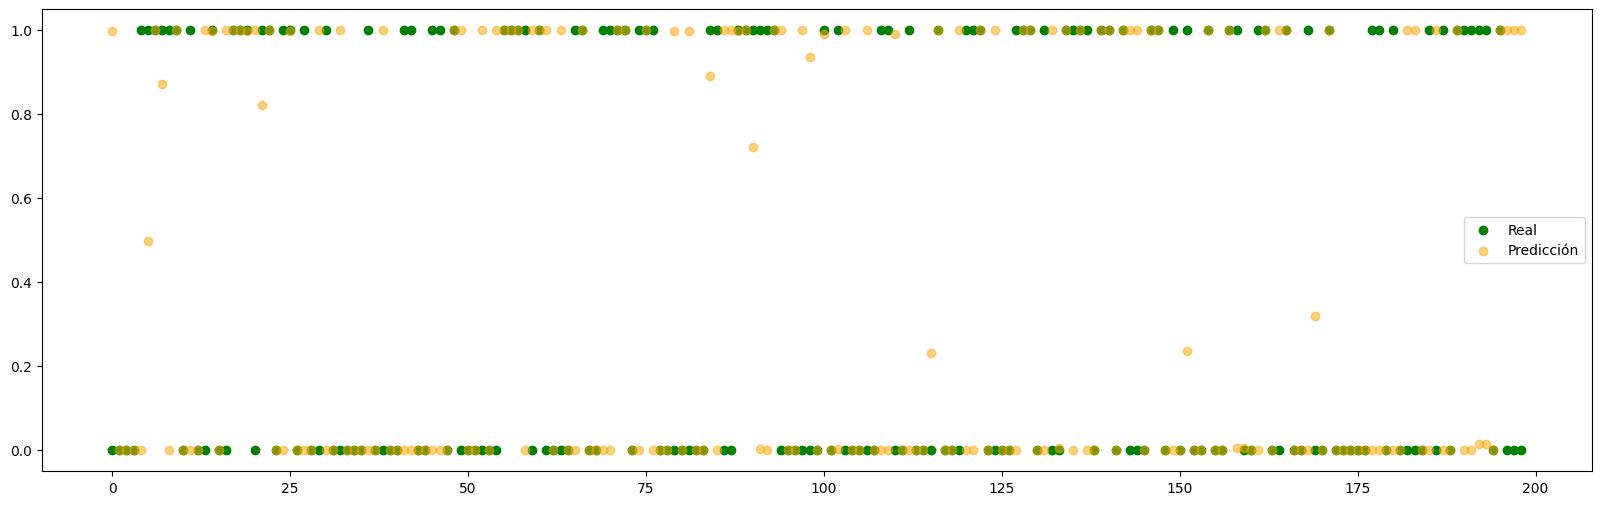

In [27]:
# Representacion gráfica del ajuste del modelo (probabilidades y valores reales).
import matplotlib.pyplot as plt

docs_len = 199
indexes = [*range(len(y_pred))][:docs_len]

fig, ax = plt.subplots(figsize=(20,6))
ax.scatter(indexes, y_test[:docs_len], label='Real', color='green', alpha=1.0)
ax.scatter(indexes, probabilities[:,1][:docs_len], label='Predicción', color='orange', alpha=0.5)
ax.legend()
plt.show()

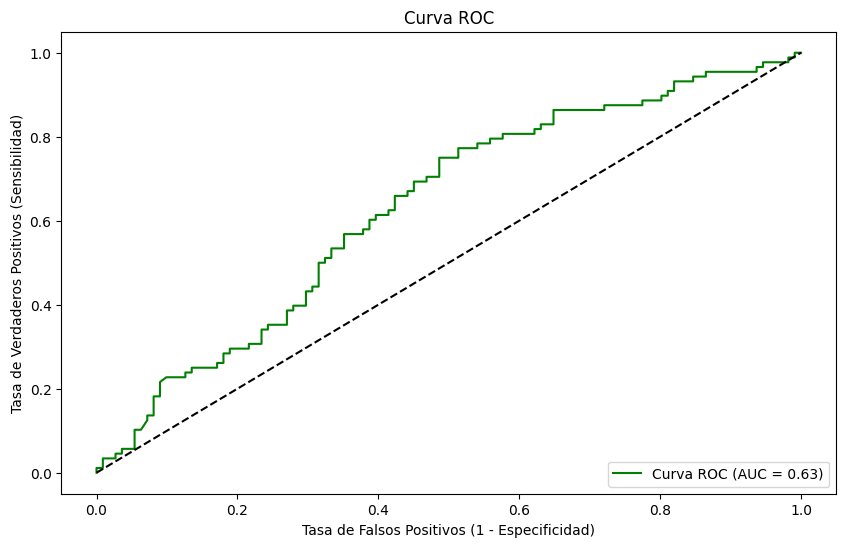

In [28]:
# Representación gráfica de la curva ROC-AUC.
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcula la curva ROC.
fpr, tpr, thresholds = roc_curve(y_test, probabilities[:,1])

# Calcula el valor AUC.
auc = roc_auc_score(y_test, probabilities[:,1])

# Grafica la curva ROC.
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(fpr, tpr, label='Curva ROC (AUC = %0.2f)' % auc, color="green")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

In [29]:
# Limpieza de memoria.
import gc

# Garbage collector.
gc.collect()

# Limpieza de memoria cache.
torch.cuda.empty_cache()

## 8. Conclusiones

De la ejecución de los tres modelos seleccionados, se obtuvo una mejor perfomance, medida en términos de accuracy y area bajo la curva, a partir del tokenizado y modelado a través de BGE Embedding.

De las pruebas realizadas, se observa que el modelo con arquitectura BERT arroja mejores resultados con un número de épocas más cercano a 50. No obstante ello, como pruebas futuras a realizar, se podrían aplicar otras capas o medidas de regularización para evitar sobreajuste del modelo.